In [95]:
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import plotly.graph_objects as go
import scipy as stats

In [96]:
start = dt.datetime(2005,1,1)
end = dt.datetime.today()
yf.pdr_override()
df = pdr.get_data_yahoo('TITAN.NS',start,end)
df=df[df['Volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
4763,3476.000000,3488.800049,3257.000000,3280.149902,3280.149902,6891728
4764,3330.000000,3332.000000,3227.000000,3270.899902,3270.899902,3111444
4765,3275.399902,3281.000000,3238.449951,3259.850098,3259.850098,2054981
4766,3259.850098,3322.500000,3233.000000,3245.699951,3245.699951,1860654
4767,3258.100098,3306.199951,3242.750000,3289.850098,3289.850098,1305917


In [97]:
df.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume'}, inplace =True)

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\1402928550.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
df['EMA'] = ta.ema(df.close,length=150)
df.tail()

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\2667145927.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,open,high,low,Close,close,volume,EMA
4763,3476.000000,3488.800049,3257.000000,3280.149902,3280.149902,6891728,3503.150058
4764,3330.000000,3332.000000,3227.000000,3270.899902,3270.899902,3111444,3500.073897
4765,3275.399902,3281.000000,3238.449951,3259.850098,3259.850098,2054981,3496.892125
4766,3259.850098,3322.500000,3233.000000,3245.699951,3245.699951,1860654,3493.565076
4767,3258.100098,3306.199951,3242.750000,3289.850098,3289.850098,1305917,3490.866864


In [99]:
EMAsignal = [0]*len(df)
backcandles= 15 

for row in range(backcandles,len(df)):
    upt=1
    dnt=1
    for i in range(row-backcandles,row+1):
        if max(df.open[i],df.close[i])>=df.EMA[i]:
            dnt=0
        if min(df.open[i],df.close[i])<=df.EMA[i]:
            upt=0
    if upt==1 and dnt==1 :
        EMAsignal[row]=3
    elif upt==1:
        EMAsignal[row]=2
    elif dnt==1:
        EMAsignal[row]=1
df['EMAsignal'] = EMAsignal

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\2217955075.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
def isPivot(candle,window):
    if candle-window <0 or candle+window>=len(df):
        return 0

    pivotHigh=1
    pivotLow=2
    for i in range(candle-window,candle+window+1):
        if df.iloc[candle].low > df.iloc[i].low:
            pivotLow=0
        if df.iloc[candle].high < df.iloc[i].high:
            pivotHigh=0
    if( pivotHigh and pivotLow):
        return 3
    elif pivotHigh:
        return pivotHigh
    elif pivotLow:
        return pivotLow
    else:
        return 0

In [101]:
window =10 
df['isPivot'] = df.apply(lambda x: isPivot(x.name,window),axis=1)

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\1466689464.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
def pointposition(x):
    if x['isPivot']==2:
        return x['low']-1e-3
    elif x['isPivot']==1:
        return x['high']+1e-3
    else:
        return np.nan
df['pointposition'] = df.apply(lambda row:pointposition(row),axis=1)

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\545382623.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
def detect_pattern(candle,backcandles,window):
    if(candle<=(backcandles+window)) or (candle+window+1 >= len(df)):
        return 0
    localdf = df.iloc[candle-backcandles-window:candle-window]
    highs = localdf[localdf['isPivot']==1].high.tail(3).values
    lows = localdf[localdf['isPivot']==2].low.tail(3).values
    cmp= localdf['Close'].values
    levelbreak = 0
    zone_width = cmp.mean()*0.05
    if len(lows)==3:
        support_condition = True
        mean_low = lows.mean()
        for low in lows:
            if abs(low-mean_low)>zone_width:
                support_condition =False
                break
        if support_condition and (mean_low - df.iloc[candle].close)> zone_width*2 and df.iloc[candle].EMAsignal==1:
            levelbreak=1
            
    if len(highs)==3:
        resistance_condition = True
        mean_high = highs.mean()
        for high in highs:
            if abs(high-mean_high)>  zone_width:
                resistance_condition =False
                break
        if resistance_condition and (df.iloc[candle].close - mean_high)> zone_width*2 and df.iloc[candle].EMAsignal==2:
            levelbreak=2
    return levelbreak

In [104]:
df['pattern'] = df.apply(lambda row: detect_pattern(row.name,backcandles=60,window=9),axis=1)

C:\Users\91907\AppData\Local\Temp\ipykernel_18856\3353784135.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
# df['Signal']
# for row in len(df):
#     if df.pattern[row] == 0:
#         df.Signal="null"
#     elif df.pattern[row]==1:
#         df.Signal[row]="Bearish"
#     else:
#         df.Signal[row]="Bullish"

In [106]:
df[df['pattern']!=0]

,open,high,low,Close,close,volume,EMA,EMAsignal,isPivot,pointposition,pattern
3161,725.700012,824.650024,725.700012,783.700012,766.722717,21820434,544.357416,2,1,824.651024,2
3162,778.000000,779.799988,748.500000,753.799988,737.470398,5830428,546.915204,2,0,NaN,2
3163,757.549988,761.450012,738.950012,743.299988,727.197815,2994196,549.303053,2,0,NaN,2
3164,740.200012,779.700012,740.200012,777.900024,761.048462,5216016,552.107628,2,0,NaN,2
3165,769.150024,791.900024,766.599976,782.049988,765.108459,3225337,554.928831,2,0,NaN,2
3166,780.000000,790.549988,762.299988,765.099976,748.525513,1082635,557.493025,2,0,NaN,2
3167,765.000000,783.450012,757.650024,774.299988,757.526367,1514814,560.142473,2,0,NaN,2
3168,745.000000,778.500000,745.000000,771.049988,754.346680,1512882,562.714715,2,0,NaN,2
3169,771.200012,777.650024,765.900024,768.299988,751.656311,794968,565.217252,2,0,NaN,2
3170,778.400024,798.000000,774.500000,786.299988,769.266357,2404092,567.919889,2,0,NaN,2


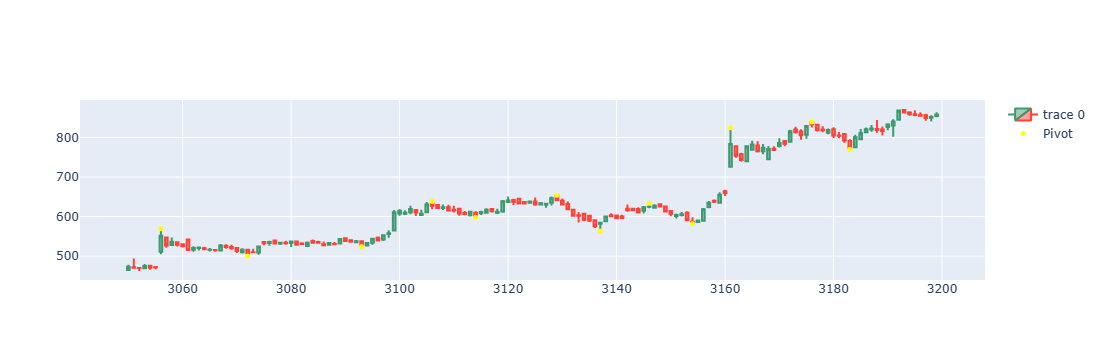

In [107]:
dfpl = df[3050:3200]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                                     open=dfpl['open'],
                                     high=dfpl['high'],
                                     low=dfpl['low'],
                                     close=dfpl['Close'])])
fig.add_scatter(x=dfpl.index,y=dfpl['pointposition'],mode="markers",
                marker=dict(size=5,color="Yellow"),
                name="Pivot")

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()